# TabNet 폐업률 예측 모델 - Data Leakage 완전 제거 버전

**주요 수정사항:**
1. 타겟 변수: t 시점 데이터 → t+1 시점 폐업 위험 예측
2. 폐업_률, 폐업_점포_수 특성 완전 제거
3. 현재 분기(t) 데이터 사용 금지 - 오직 과거(t-1, t-2) 데이터만 사용
4. 그룹 통계량은 train에서만 계산

## 0. 라이브러리 임포트 및 GPU 설정

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)
from pytorch_tabnet.tab_model import TabNetClassifier
import warnings
warnings.filterwarnings('ignore')

# 시드 설정
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# GPU 설정
if torch.backends.mps.is_available():
    device = 'mps'
    print("✓ Mac GPU 사용")
elif torch.cuda.is_available():
    device = 'cuda'
    print("✓ NVIDIA GPU 사용")
else:
    device = 'cpu'
    print("✓ CPU 사용")

✓ Mac GPU 사용


## 1. 데이터 로드

In [3]:
print("\n" + "="*80)
print("1. 데이터 로드")
print("="*80)

# merged_data.csv 있는 폴더 경로 -> 수정 필요
data_path = '/Users/kimjm/Desktop/SKN_19/SKN19_2nd_1team/eda/data/merged_data.csv'
df = pd.read_csv(data_path)
print(f"✓ 데이터 Shape: {df.shape}")
print(f"✓ 기간: {df['기준_년분기_코드'].min()} ~ {df['기준_년분기_코드'].max()}")


1. 데이터 로드
✓ 데이터 Shape: (39975, 137)
✓ 기간: 20191 ~ 20252


## 2. 타겟 변수 생성 (미래 시점 예측)

In [4]:
print("\n" + "="*80)
print("2. 타겟 변수 생성")
print("="*80)

# 시간 변수 생성
df['year'] = df['기준_년분기_코드'].astype(str).str[:4].astype(int)
df['quarter'] = df['기준_년분기_코드'].astype(str).str[4:].astype(int)
df['year_quarter'] = df['year'] * 10 + df['quarter']

# 범주형 인코딩
le_district = LabelEncoder()
df['자치구_encoded'] = le_district.fit_transform(df['자치구_코드_명'])

le_industry = LabelEncoder()
df['업종_encoded'] = le_industry.fit_transform(df['서비스_업종_코드_명'])

le_change = LabelEncoder()
df['상권변화_encoded'] = le_change.fit_transform(df['상권_변화_지표'])

# 시계열 정렬
df = df.sort_values(['자치구_encoded', '업종_encoded', 'year_quarter']).reset_index(drop=True)



# 타겟 변수 생성 (전체 데이터의 중앙값 기준)
threshold = df['폐업_률'].quantile(0.5)
df['closure_risk'] = (df['폐업_률'] >= threshold).astype(int)

print(f"✓ 폐업률 임계값: {threshold:.2f}%")
print(f"✓ 클래스 분포:")
print(df['closure_risk'].value_counts())

# 타겟이 없는 마지막 분기 데이터 제거
df = df.dropna(subset=['폐업_률']).reset_index(drop=True)
print(f"✓ 타겟 생성 후 데이터 Shape: {df.shape}")


2. 타겟 변수 생성
✓ 폐업률 임계값: 2.30%
✓ 클래스 분포:
closure_risk
1    20320
0    19655
Name: count, dtype: int64
✓ 타겟 생성 후 데이터 Shape: (39975, 144)


## 3. 특성 생성 - 과거 시점 데이터만 사용 (Data Leakage 방지)

**중요:**
- 🚫 폐업_률, 폐업_점포_수는 절대 사용하지 않음
- ✅ 오직 t-1, t-2 시점 데이터만 사용

In [5]:
print("\n" + "="*80)
print("3. 특성 생성")
print("="*80)

# 특성공학에 사용할 컬럼/lag data 만들 컬럼
# 폐업_률, 폐업_점포_수는 절대 사용하지 않음!
lag_cols = [
    '당월_매출_금액', '당월_매출_건수', '점포_수', '유사_업종_점포_수',
    '프랜차이즈_점포_수', '개업_률', '개업_점포_수',
    '전체임대료', '총_유동인구_수', '총_상주인구_수', '총_직장인구_수',
    '토요일_매출_금액', '일요일_매출_금액', '시간대_21_24_매출_금액',
    '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
    '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액'
]

print(f"✓ Lag 특성 생성 대상: {len(lag_cols)}개 컬럼")

# Lag 특성 생성 (t-1, t-2)
# 이전분기, 2분기전 데이터
for col in lag_cols:
    df[f'{col}_lag1'] = df.groupby(['자치구_encoded', '업종_encoded'])[col].shift(1)
    df[f'{col}_lag2'] = df.groupby(['자치구_encoded', '업종_encoded'])[col].shift(2)

print(f"✓ Lag 특성 생성 완료: {len(lag_cols) * 2}개 특성 추가")


3. 특성 생성
✓ Lag 특성 생성 대상: 20개 컬럼
✓ Lag 특성 생성 완료: 40개 특성 추가


## 4. 파생 특성 생성 (모두 t-1, t-2 시점 기반)

In [6]:
print("\n" + "="*80)
print("4. 파생 특성 생성")
print("="*80)

# 변화율 (t-1과 t-2 비교)
df['매출_변화율'] = (df['당월_매출_금액_lag1'] - df['당월_매출_금액_lag2']) / (df['당월_매출_금액_lag2'] + 1)
df['매출건수_변화율'] = (df['당월_매출_건수_lag1'] - df['당월_매출_건수_lag2']) / (df['당월_매출_건수_lag2'] + 1)
df['점포수_변화율'] = (df['점포_수_lag1'] - df['점포_수_lag2']) / (df['점포_수_lag2'] + 1)
df['개업률_변화'] = df['개업_률_lag1'] - df['개업_률_lag2']

# 연속 하락 (t-2, t-1 시점 기준)
df['매출_감소'] = (df['매출_변화율'] < 0).astype(int)
df['연속_매출_감소'] = df.groupby(['자치구_encoded', '업종_encoded'])['매출_감소'].shift(1).rolling(2, min_periods=1).sum()

# 과거 추세
df['매출_3분기_평균'] = df.groupby(['자치구_encoded', '업종_encoded'])['당월_매출_금액_lag1'].shift(1).rolling(3, min_periods=1).mean()
df['매출_추세_대비'] = df['당월_매출_금액_lag1'] / (df['매출_3분기_평균'] + 1)

# 수익성 지표 (t-1 시점)
df['점포당_매출'] = df['당월_매출_금액_lag1'] / (df['점포_수_lag1'] + 1)
df['건당_매출'] = df['당월_매출_금액_lag1'] / (df['당월_매출_건수_lag1'] + 1)
df['임대료_부담률'] = df['전체임대료_lag1'] / (df['당월_매출_금액_lag1'] + 1)
df['유동인구_전환율'] = df['당월_매출_건수_lag1'] / (df['총_유동인구_수_lag1'] + 1)

# 고객 구조 (t-1 시점)
age_cols_lag1 = [f'연령대_{age}_매출_금액_lag1' for age in ['10', '20', '30', '40', '50', '60_이상']]
df['최대_연령대_비중'] = df[age_cols_lag1].max(axis=1) / (df['당월_매출_금액_lag1'] + 1)
df['주말_매출_비율'] = (df['토요일_매출_금액_lag1'] + df['일요일_매출_금액_lag1']) / (df['당월_매출_금액_lag1'] + 1)
df['야간_매출_비율'] = df['시간대_21_24_매출_금액_lag1'] / (df['당월_매출_금액_lag1'] + 1)

# 경쟁 환경 (t-1 시점)
df['프랜차이즈_비율'] = df['프랜차이즈_점포_수_lag1'] / (df['점포_수_lag1'] + 1)
df['경쟁_밀도'] = df['유사_업종_점포_수_lag1'] / (df['점포_수_lag1'] + 1)
df['점포_포화도'] = df['점포_수_lag1'] / ((df['총_상주인구_수_lag1'] + df['총_직장인구_수_lag1']) + 1) * 10000

print(f"✓ 파생 특성 생성 완료")

# 결측값 처리
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)


4. 파생 특성 생성


✓ 파생 특성 생성 완료


## 5. Feature 선택

**핵심:**
- 현재 시점(t)의 모든 원본 데이터 제외
- 오직 lag 특성(_lag1, _lag2)만 사용

In [7]:
print("\n" + "="*80)
print("5. Feature 선택")
print("="*80)

# 범주형 변수
categorical_features = ['자치구_encoded', '업종_encoded', '상권변화_encoded']

# 제외할 컬럼들
exclude_cols = [
    # 원본 범주형 변수
    '기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명', '상권_변화_지표',

    # 🚫 타겟 변수 및 현재 시점(t) 모든 데이터
    '폐업_률', '폐업_점포_수', 'closure_risk',

    # 🚫 현재 시점(t)의 모든 원본 데이터 (lag가 없는 컬럼들)
    '당월_매출_금액', '당월_매출_건수', '점포_수', '유사_업종_점포_수',
    '프랜차이즈_점포_수', '개업_률', '개업_점포_수',
    '전체임대료', '총_유동인구_수', '총_상주인구_수', '총_직장인구_수',
    '토요일_매출_금액', '일요일_매출_금액', '시간대_21_24_매출_금액',
    '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
    '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액',

    # 시간 정보
    'year', 'quarter', 'year_quarter',

    # 기타 현재 시점 데이터 (모두 제외)
    '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액',
    '시간대_00_06_매출_금액', '시간대_06_11_매출_금액', '시간대_11_14_매출_금액',
    '시간대_14_17_매출_금액', '시간대_17_21_매출_금액',
    '남성_매출_금액', '여성_매출_금액',
    '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
    '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수',
    '시간대_건수~06_매출_건수', '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수',
    '시간대_건수~17_매출_건수', '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수',
    '남성_매출_건수', '여성_매출_건수',
    '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수',
    '연령대_40_매출_건수', '연령대_50_매출_건수', '연령대_60_이상_매출_건수',
    '운영_영업_개월_평균', '폐업_영업_개월_평균', '서울시_운영_영업_개월_평균', '서울시_폐업_영업_개월_평균',
    '남성_유동인구_수', '여성_유동인구_수',
    '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수',
    '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수',
    '시간대_00_06_유동인구_수', '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수',
    '시간대_14_17_유동인구_수', '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수',
    '월요일_유동인구_수', '화요일_유동인구_수', '수요일_유동인구_수', '목요일_유동인구_수',
    '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수',
    '월_평균_소득_금액', '지출_총_금액', '식료품_지출_총금액', '의류_신발_지출_총금액',
    '생활용품_지출_총금액', '의료비_지출_총금액', '교통_지출_총금액', '교육_지출_총금액',
    '유흥_지출_총금액', '여가_문화_지출_총금액', '기타_지출_총금액', '음식_지출_총금액',
    '남성_상주인구_수', '여성_상주인구_수',
    '연령대_10_미만_상주인구_수', '연령대_20_상주인구_수', '연령대_30_상주인구_수',
    '연령대_40_상주인구_수', '연령대_50_상주인구_수', '연령대_60_이상_상주인구_수',
    '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
    '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
    '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
    '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
    '총_가구_수', '남성_직장인구_수', '여성_직장인구_수',
    '연령대_10_직장인구_수', '연령대_20_직장인구_수', '연령대_30_직장인구_수',
    '연령대_40_직장인구_수', '연령대_50_직장인구_수', '연령대_60_이상_직장인구_수',
    '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
    '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
    '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
    '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수'
]

# 사용 가능한 feature 선택
feature_cols = [col for col in df.columns if col not in exclude_cols]

# 범주형 feature의 인덱스 및 차원 설정
cat_idxs = [feature_cols.index(col) for col in categorical_features if col in feature_cols]
cat_dims = [
    len(le_district.classes_),
    len(le_industry.classes_),
    len(le_change.classes_)
]

print(f"✓ 전체 컬럼 수: {len(df.columns)}")
print(f"✓ 제외 컬럼 수: {len(exclude_cols)}")
print(f"✓ 사용 feature 수: {len(feature_cols)}")
print(f"✓ 범주형 feature: {len(categorical_features)}개")
print(f"  - cat_idxs: {cat_idxs}")
print(f"  - cat_dims: {cat_dims}")


5. Feature 선택
✓ 전체 컬럼 수: 202
✓ 제외 컬럼 수: 141
✓ 사용 feature 수: 61
✓ 범주형 feature: 3개
  - cat_idxs: [0, 1, 2]
  - cat_dims: [25, 63, 4]


## 6. 데이터 분할 (시계열 기준)

In [8]:
print("\n" + "="*80)
print("6. 데이터 분할 - 시계열 기준")
print("="*80)

# 1. 결측값 제거
df_clean = df.dropna(subset=feature_cols).reset_index(drop=True)

# 2. 각 그룹의 초기 데이터 제거 (lag2 생성 이후부터 사용)
# lag2 사용할 경우 처음 2분기까지는 데이터가 모두 0으로 처리됨
df_clean = df_clean.groupby(['자치구_encoded', '업종_encoded'], group_keys=False).apply(
    lambda x: x.iloc[2:] if len(x) > 2 else x  # 각 그룹에서 처음 2개 분기 제거
).reset_index(drop=True)

# 3. 시계열 정렬
df_sorted = df_clean.sort_values(
    ['year_quarter', '자치구_encoded', '업종_encoded']
).reset_index(drop=True)

print(f"✓ 초기 분기 제거 후 Shape: {df_sorted.shape}")

# Train/Val/Test 분할
train_size = 0.7
val_size = 0.1
test_size = 0.2

n_total = len(df_sorted)
n_train = int(n_total * train_size)
n_val = int(n_total * val_size)

train_df = df_sorted.iloc[:n_train].copy()
val_df = df_sorted.iloc[n_train:n_train+n_val].copy()
test_df = df_sorted.iloc[n_train+n_val:].copy()

print(f"✓ Train: {len(train_df)} ({len(train_df)/n_total*100:.1f}%)")
print(f"  - Class 0: {(train_df['closure_risk']==0).sum()}, Class 1: {(train_df['closure_risk']==1).sum()}")
print(f"✓ Validation: {len(val_df)} ({len(val_df)/n_total*100:.1f}%)")
print(f"  - Class 0: {(val_df['closure_risk']==0).sum()}, Class 1: {(val_df['closure_risk']==1).sum()}")
print(f"✓ Test: {len(test_df)} ({len(test_df)/n_total*100:.1f}%)")
print(f"  - Class 0: {(test_df['closure_risk']==0).sum()}, Class 1: {(test_df['closure_risk']==1).sum()}")


6. 데이터 분할 - 시계열 기준
✓ 초기 분기 제거 후 Shape: (36875, 202)
✓ Train: 25812 (70.0%)
  - Class 0: 12938, Class 1: 12874
✓ Validation: 3687 (10.0%)
  - Class 0: 1705, Class 1: 1982
✓ Test: 7376 (20.0%)
  - Class 0: 3568, Class 1: 3808


## 7. 그룹 통계량 계산 - Train 데이터만 사용 (Leakage 방지)

**핵심:**
- Train에서만 그룹 평균 계산
- Val/Test는 Train의 통계량 사용

In [9]:
print("\n" + "="*80)
print("7. 그룹 통계량 계산 - Train 데이터만 사용 (Leakage 방지)")
print("="*80)

# Train에서만 그룹 평균 계산
district_sales_mean = train_df.groupby('자치구_encoded')['당월_매출_금액_lag1'].mean()
industry_sales_mean = train_df.groupby('업종_encoded')['당월_매출_금액_lag1'].mean()

# 모든 세트에 적용 (train의 통계량 사용)
train_df['상권_매출_평균'] = train_df['자치구_encoded'].map(district_sales_mean)
train_df['업종_매출_평균'] = train_df['업종_encoded'].map(industry_sales_mean)

val_df['상권_매출_평균'] = val_df['자치구_encoded'].map(district_sales_mean)
val_df['업종_매출_평균'] = val_df['업종_encoded'].map(industry_sales_mean)

test_df['상권_매출_평균'] = test_df['자치구_encoded'].map(district_sales_mean)
test_df['업종_매출_평균'] = test_df['업종_encoded'].map(industry_sales_mean)

# 상대 지표 계산
for dataset in [train_df, val_df, test_df]:
    dataset['상권_대비_매출'] = dataset['당월_매출_금액_lag1'] / (dataset['상권_매출_평균'] + 1)
    dataset['업종_대비_매출'] = dataset['당월_매출_금액_lag1'] / (dataset['업종_매출_평균'] + 1)

    # 위험 점수 (t-1 시점 데이터 기반)
    dataset['위험_점수'] = (
        (dataset['매출_변화율'] < -0.1).astype(int) * 2 +
        (dataset['임대료_부담률'] > 0.3).astype(int) * 2 +
        (dataset['상권_대비_매출'] < 0.7).astype(int) +
        (dataset.get('연속_매출_감소', 0) >= 2).astype(int) * 3
    )

# Feature 리스트 업데이트
additional_features = ['상권_매출_평균', '업종_매출_평균', '상권_대비_매출', '업종_대비_매출', '위험_점수']
feature_cols.extend(additional_features)

# 범주형 인덱스 업데이트
cat_idxs = [feature_cols.index(col) for col in categorical_features if col in feature_cols]

print(f"✓ 최종 feature 수: {len(feature_cols)}")
print(f"✓ 그룹 통계량 기반 특성 추가: {len(additional_features)}개")

# 결측값 처리
train_df = train_df.replace([np.inf, -np.inf], np.nan).fillna(0)
val_df = val_df.replace([np.inf, -np.inf], np.nan).fillna(0)
test_df = test_df.replace([np.inf, -np.inf], np.nan).fillna(0)


7. 그룹 통계량 계산 - Train 데이터만 사용 (Leakage 방지)
✓ 최종 feature 수: 66
✓ 그룹 통계량 기반 특성 추가: 5개


---

##### 데이터 저장 - 공유용

In [10]:
# train_df, val_df, test_df에서 feature_cols만 추출해서 저장
train_features = train_df[feature_cols]
train_target = train_df['closure_risk']

val_features = val_df[feature_cols]
val_target = val_df['closure_risk']

test_features = test_df[feature_cols]
test_target = test_df['closure_risk']

# 저장.1 (validation set 분할 필요한 경우) - 파일 경로 수정 필요
train_features.to_csv('./preprocessed/train_features.csv', index=False)
train_target.to_csv('./preprocessed/train_target.csv', index=False)
val_features.to_csv('./preprocessed/val_features.csv', index=False)
val_target.to_csv('./preprocessed/val_target.csv', index=False)
test_features.to_csv('./preprocessed/test_features.csv', index=False)
test_target.to_csv('./preprocessed/test_target.csv', index=False)

# 저장.2 (validation set 따로 분할 필요 없는 경우)
# train_val_features = pd.concat([train_features, val_features], axis=0)
# train_val_target = pd.concat([train_target, val_target], axis=0)
# train_val_features.to_csv('./preprocessed/train_val.csv', index=False)
# train_val_target.to_csv('./preprocessed/train_target.csv', index=False)
# test_features.to_csv('./preprocessed/test_features.csv', index=False)
# test_target.to_csv('./preprocessed/test_target.csv', index=False)

print('데이터 저장 완료')

데이터 저장 완료


---

## 8. 데이터 준비 및 스케일링

In [11]:
print("\n" + "="*80)
print("8. 데이터 준비 및 스케일링")
print("="*80)

# 데이터 추출
X_train = train_df[feature_cols].values
y_train = train_df['closure_risk'].values

X_val = val_df[feature_cols].values
y_val = val_df['closure_risk'].values

X_test = test_df[feature_cols].values
y_test = test_df['closure_risk'].values

# 범주형과 연속형 분리
categorical_mask = np.zeros(len(feature_cols), dtype=bool)
for idx in cat_idxs:
    categorical_mask[idx] = True
continuous_mask = ~categorical_mask

# Feature 스케일링 (연속형 변수만)
scaler = StandardScaler()
X_train_continuous = X_train[:, continuous_mask].astype(np.float64)
X_val_continuous = X_val[:, continuous_mask].astype(np.float64)
X_test_continuous = X_test[:, continuous_mask].astype(np.float64)

X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
X_val_continuous_scaled = scaler.transform(X_val_continuous)
X_test_continuous_scaled = scaler.transform(X_test_continuous)

# 범주형과 스케일링된 연속형 결합
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[:, continuous_mask] = X_train_continuous_scaled
X_val_scaled[:, continuous_mask] = X_val_continuous_scaled
X_test_scaled[:, continuous_mask] = X_test_continuous_scaled

# MPS 호환성 
if device == 'mps':
    X_train_scaled = X_train_scaled.astype(np.float32)
    X_val_scaled = X_val_scaled.astype(np.float32)
    X_test_scaled = X_test_scaled.astype(np.float32)

print(f"✓ 연속형 feature 수: {continuous_mask.sum()}개")
print(f"✓ 범주형 feature 수: {categorical_mask.sum()}개")


8. 데이터 준비 및 스케일링
✓ 연속형 feature 수: 63개
✓ 범주형 feature 수: 3개


## 9. TabNet 모델 학습

In [12]:
print("\n" + "="*80)
print("9. TabNet 모델 학습")
print("="*80)

model = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=1.4,
    lambda_sparse=0.000009,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params={"step_size": 50, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',
    seed=SEED,
    verbose=1,
    device_name=device,
)

print("\n✓ 모델 학습 시작\n")
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric=['accuracy', 'auc', 'logloss'],
    max_epochs=150,
    patience=25,
    batch_size=1024,
    virtual_batch_size=128
)

print(f"\n✓ 학습 완료")
print(f"  - Best Epoch: {model.best_epoch}")
print(f"  - Best Loss: {model.best_cost:.6f}")


9. TabNet 모델 학습

✓ 모델 학습 시작

epoch 0  | loss: 0.77035 | val_0_accuracy: 0.60835 | val_0_auc: 0.66398 | val_0_logloss: 0.68461 |  0:00:10s
epoch 1  | loss: 0.67067 | val_0_accuracy: 0.64578 | val_0_auc: 0.71755 | val_0_logloss: 0.63705 |  0:00:15s
epoch 2  | loss: 0.62395 | val_0_accuracy: 0.67752 | val_0_auc: 0.74781 | val_0_logloss: 0.60911 |  0:00:21s
epoch 3  | loss: 0.59473 | val_0_accuracy: 0.68755 | val_0_auc: 0.76431 | val_0_logloss: 0.58628 |  0:00:26s
epoch 4  | loss: 0.5859  | val_0_accuracy: 0.69325 | val_0_auc: 0.7706  | val_0_logloss: 0.573   |  0:00:32s
epoch 5  | loss: 0.57985 | val_0_accuracy: 0.68918 | val_0_auc: 0.77285 | val_0_logloss: 0.57332 |  0:00:38s
epoch 6  | loss: 0.57331 | val_0_accuracy: 0.69379 | val_0_auc: 0.77353 | val_0_logloss: 0.56884 |  0:00:43s
epoch 7  | loss: 0.57038 | val_0_accuracy: 0.68565 | val_0_auc: 0.77779 | val_0_logloss: 0.56731 |  0:00:49s
epoch 8  | loss: 0.56691 | val_0_accuracy: 0.69189 | val_0_auc: 0.77996 | val_0_logloss: 0.56295 |

## 10. 모델 평가 - Data Leakage 제거 후 실제 성능

In [13]:
print("\n" + "="*80)
print("10. 모델 평가")
print("="*80)

# 최적 임계값 찾기
y_val_proba = model.predict_proba(X_val_scaled)
fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_proba[:, 1])
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = roc_thresholds[optimal_idx]

print(f"✓ 최적 임계값: {optimal_threshold:.4f}")

# 테스트 세트 평가
y_test_proba = model.predict_proba(X_test_scaled)
y_test_pred = (y_test_proba[:, 1] >= optimal_threshold).astype(int)

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_proba[:, 1])

print(f"\n{'='*80}")
print(f"{'테스트 세트 최종 성능':^80}")
print(f"{'='*80}")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1 Score:  {f1:.4f}")
print(f"  AUC:       {auc:.4f}")
print(f"{'='*80}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n✓ Confusion Matrix:")
print(cm)

# Classification Report
print(f"\n✓ Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Low Risk', 'High Risk']))


10. 모델 평가
✓ 최적 임계값: 0.4401

                                  테스트 세트 최종 성능                                  
  Accuracy:  0.7061 (70.61%)
  Precision: 0.7221 (72.21%)
  Recall:    0.7001 (70.01%)
  F1 Score:  0.7109
  AUC:       0.7807

✓ Confusion Matrix:
[[2542 1026]
 [1142 2666]]

✓ Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.69      0.71      0.70      3568
   High Risk       0.72      0.70      0.71      3808

    accuracy                           0.71      7376
   macro avg       0.71      0.71      0.71      7376
weighted avg       0.71      0.71      0.71      7376



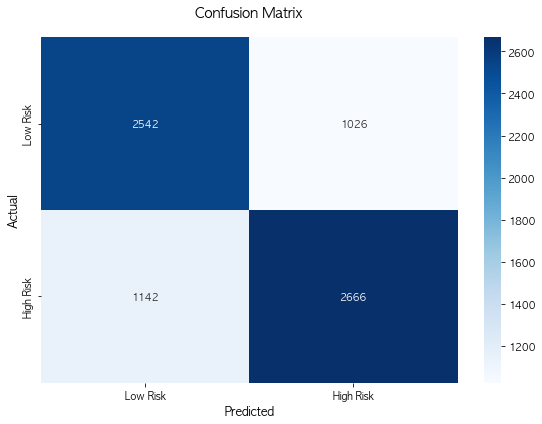

In [ ]:
# Confusion Matrix 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc  ### 이 줄과
rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Low Risk', 'High Risk'],
    yticklabels=['Low Risk', 'High Risk'],
    ax=ax
)
ax.set_title('Confusion Matrix', fontsize=14, pad=20)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

## 11. Feature Importance (Top 20)

In [15]:
print("\n" + "="*80)
print("11. Feature Importance (Top 20)")
print("="*80)

feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importances
}).sort_values('importance', ascending=False).head(20)

print(importance_df.to_string(index=False))


11. Feature Importance (Top 20)
          feature  importance
         야간_매출_비율    0.218798
        개업_률_lag1    0.074865
     개업_점포_수_lag1    0.061052
        점포_수_lag2    0.059339
  프랜차이즈_점포_수_lag1    0.053854
         주말_매출_비율    0.043926
            건당_매출    0.038899
       업종_encoded    0.037672
        개업_률_lag2    0.033754
  프랜차이즈_점포_수_lag2    0.033502
    총_상주인구_수_lag2    0.033294
    당월_매출_건수_lag2    0.030518
    당월_매출_건수_lag1    0.025189
    총_직장인구_수_lag2    0.023896
         매출건수_변화율    0.018345
연령대_50_매출_금액_lag2    0.017501
    당월_매출_금액_lag1    0.015315
          임대료_부담률    0.015127
            위험_점수    0.013179
연령대_40_매출_금액_lag2    0.013000


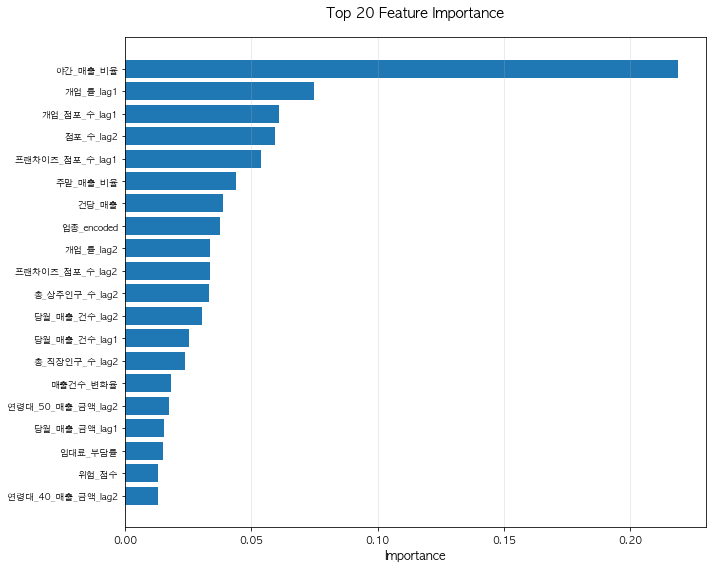

In [16]:
# Feature Importance (Top 20) 시각화
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(importance_df)), importance_df['importance'])
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['feature'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 20 Feature Importance', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()